In [9]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torch
import numpy as np
from torch.autograd import Variable 
from sys import *
from subprocess import *
import os


In [10]:
mobi_data = pd.read_csv("../data/Mobi_System_Data_2020.csv", compression='zip').dropna()
geo_data = pd.read_csv('../data/geocodings.csv',index_col=0)
data = mobi_data.merge(geo_data.rename({'lat':'Departure lat','long':'Departure long'},axis=1),left_on='Departure station',right_on='address').drop('address',axis=1)
data = data.merge(geo_data.rename({'lat':'Return lat','long':'Return long'},axis=1),left_on='Return station',right_on='address').drop('address',axis=1)
data.shape
# data = data.loc[data["Departure postal code"].str.startswith("V6")]
print(data.columns)
data["time"] = pd.to_datetime(data["Departure"], format="%Y-%m-%d %H:%M:%S")
data["hour"] = data["time"].dt.hour
data["day"] = data["time"].dt.day
data["month"] = data["time"].dt.month
data["year"] = data["time"].dt.year
stations = pd.read_csv("../data/stations.csv")
max_lat, min_lat = stations["lat"].max(), stations["lat"].min()
max_long, min_long = stations["long"].max(), stations["long"].min()

Index(['Unnamed: 0', 'Departure', 'Return', 'Bike', 'Departure station',
       'Return station', 'Membership type', 'Covered distance (m)',
       'Duration (sec.)', 'Departure battery voltage (mV)',
       'Return battery voltage (mV)', 'Departure temperature (C)',
       'Return temperature (C)', 'Stopover duration (sec.)',
       'Number of stopovers', 'postal_code_x', 'Departure lat',
       'Departure long', 'postal_code_y', 'Return lat', 'Return long'],
      dtype='object')


In [11]:
def generate_time_df(start_time, peroid):
    predict_data = pd.DataFrame(data={
        "month": [], 
        "day": [], 
        "hour": [], 
        "lat": [],
        "long": [],
        "parks": [],
        "stops": [],
        "population": [],
        "station": []})
    for row in stations.iterrows():
        time = pd.date_range(start_time, periods=peroid, freq='H')

        station_data = pd.DataFrame(data={"time": time})
        station_data["hour"] = station_data["time"].dt.hour
        station_data["day"] = station_data["time"].dt.day
        station_data["month"] = station_data["time"].dt.month
        station_data["lat"] = (row[1]["lat"] - min_lat) / (max_lat - min_lat)
        station_data["long"] = (row[1]["long"] - min_long) / (max_long - min_long)
        station_data["station"] = row[1]["station"]
        station_data["parks"] = row[1]["parks"]
        station_data["stops"] = row[1]["stops"]
        station_data["population"] = row[1]["population"]
        station_data = station_data.drop(columns=["time"])
        
        predict_data = pd.concat([predict_data, station_data])
    
    return predict_data


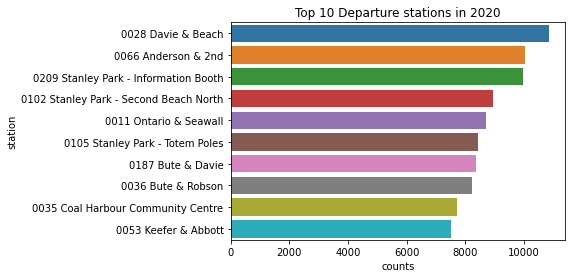

In [12]:
features_departure = ["month", "day", "hour", "lat", "long", "parks", "stops", "population"]
counts_data_departure = data.groupby(["month", "day", "hour", "Departure lat", "Departure long", "Departure station"]).size().reset_index(name='counts')
counts_data_departure = counts_data_departure.rename(columns={"Departure lat": "lat", "Departure long": "long", "Departure station": "station"})

departure_time_df = generate_time_df('2020-01-01', 8760)

train_data = departure_time_df.merge(counts_data_departure[["month", "day", "hour", "station", "counts"]], how="left", left_on=["month", "day", "hour", "station"], right_on=["month", "day", "hour", "station"])
train_data["counts"] = train_data["counts"].fillna(0)

top_stations = train_data[["station", "counts"]].groupby("station").sum().reset_index()
top_stations = top_stations.sort_values(by="counts", ascending= False).head(10)
ax = sns.barplot(x="counts", y="station", data=top_stations)
ax.set(title='Top 10 Departure stations in 2020')

train_data["month"] = train_data["month"] / 12
train_data["day"] = train_data["day"] / 31
train_data["hour"] = train_data["hour"] / 23
x = train_data[features_departure]
y = train_data["counts"]
    



In [13]:
from xgboost import XGBRegressor
model_departure = XGBRegressor()
model_departure.fit(x, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [14]:
predict_data_departure = generate_time_df('2022-05-01', 168)
predict_data_departure["month"] = predict_data_departure["month"] / 12
predict_data_departure["day"] = predict_data_departure["day"] / 31
predict_data_departure["hour"] = predict_data_departure["hour"] / 23
predict_data_departure["counts"] = model_departure.predict(predict_data_departure[features_departure])
predict_data_departure["counts"] = predict_data_departure["counts"].clip(lower=0.000001)
print(predict_data_departure["counts"].sum())

8906.581


<AxesSubplot:title={'center':'# of Departure for each hour'}, xlabel='hour'>

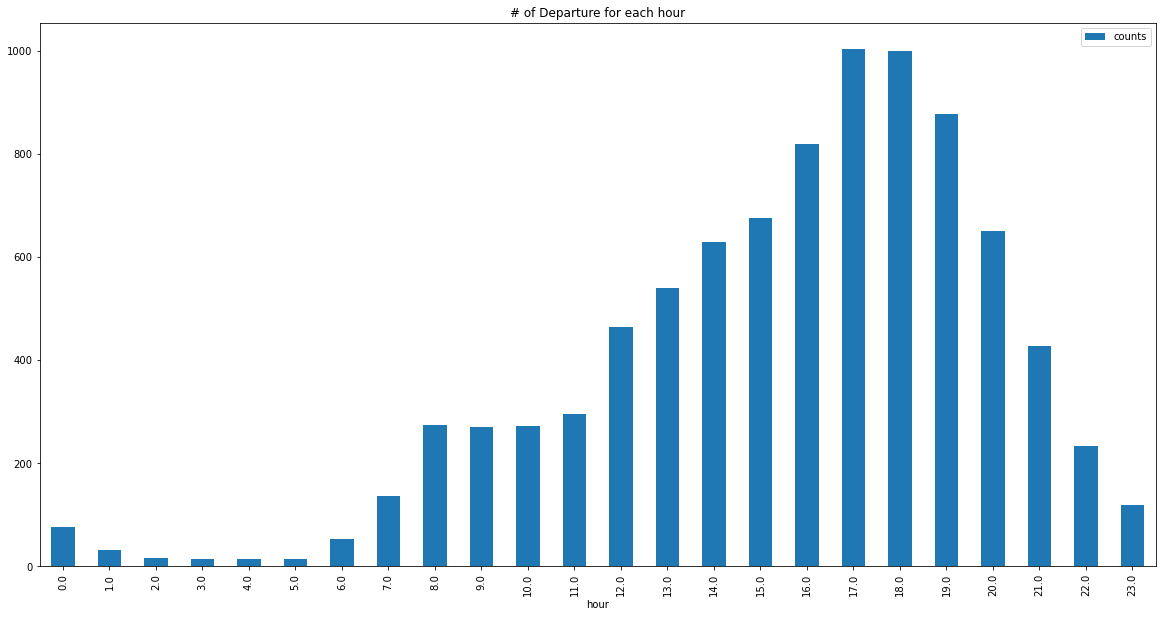

In [15]:
hours = predict_data_departure.loc[:, ["hour", "counts"]]
hours["hour"] = (hours["hour"] * 23).round()
hours = hours.groupby("hour").sum()
hours.plot(kind='bar', figsize=(20, 10), title="# of Departure for each hour")

In [16]:
# month = predict_data_departure.loc[:, ["month", "counts"]]
# month["month"] = (month["month"] * 12).round()
# month = month.groupby("month").sum()
# month.plot(kind='bar', figsize=(20, 10), title="# of Departure for each month");

[Text(0.5, 1.0, 'Top 10 departure stations')]

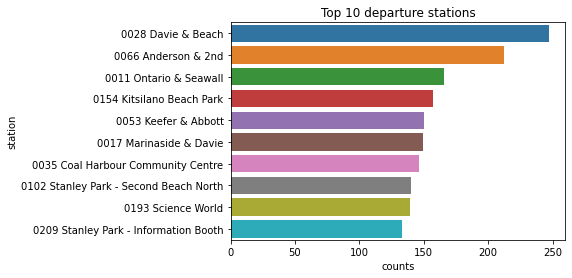

In [17]:
top_stations = predict_data_departure[["station", "counts"]].groupby("station").sum().reset_index()
top_stations = top_stations.sort_values(by="counts", ascending= False).head(10)
ax = sns.barplot(x="counts", y="station", data=top_stations)
ax.set(title="Top 10 departure stations")

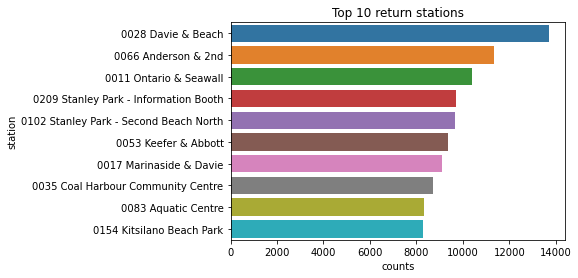

In [18]:
features_return = ["month", "day", "hour", "lat", "long", "parks", "stops", "population"]
counts_data_return = data.loc[:, ["month", "day", "hour", "Return lat", "Return long", "Return station", "Duration (sec.)"]]
counts_data_return["Duration (sec.)"] = (counts_data_return["Duration (sec.)"] / 3600).astype(int)
counts_data_return["hour"] = counts_data_return["hour"] + counts_data_return["Duration (sec.)"]
counts_data_return["day"] = counts_data_return["day"] + (counts_data_return["hour"] / 24).astype(int)
counts_data_return["hour"] = counts_data_return["hour"].mod(24)
counts_data_return = counts_data_return.drop(columns=["Duration (sec.)"])
counts_data_return = counts_data_return.groupby(["month", "day", "hour", "Return lat", "Return long", "Return station"]).size().reset_index(name='counts')
counts_data_return = counts_data_return.rename(columns={"Return lat": "lat", "Return long": "long", "Return station": "station"})
return_time_df = generate_time_df('2020-01-01', 8760)
train_data = return_time_df.merge(counts_data_return[["month", "day", "hour", "station", "counts"]], how="left", on=["month", "day", "hour", "station"])
train_data["counts"] = train_data["counts"].fillna(0)

top_stations = train_data[["station", "counts"]].groupby("station").sum().reset_index()
top_stations = top_stations.sort_values(by="counts", ascending= False).head(10)
ax = sns.barplot(x="counts", y="station", data=top_stations)
ax.set(title='Top 10 return stations')

train_data["month"] = train_data["month"] / 12
train_data["day"] = train_data["day"] / 31
train_data["hour"] = train_data["hour"] / 23
x = train_data[features_return]
y = train_data["counts"]
    

In [19]:
from xgboost import XGBRegressor
model_return = XGBRegressor()
model_return.fit(x, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [20]:
predict_data_return = generate_time_df('2022-05-01', 168)
predict_data_return["month"] = predict_data_return["month"] / 12
predict_data_return["day"] = predict_data_return["day"] / 31
predict_data_return["hour"] = predict_data_return["hour"] / 23
predict_data_return["counts"] = model_return.predict(predict_data_return[features_return])
predict_data_return["counts"] = predict_data_return["counts"].clip(lower=0.000001)
print(predict_data_return["counts"].sum())

9140.757


<AxesSubplot:title={'center':'# of Return for each hour'}, xlabel='hour'>

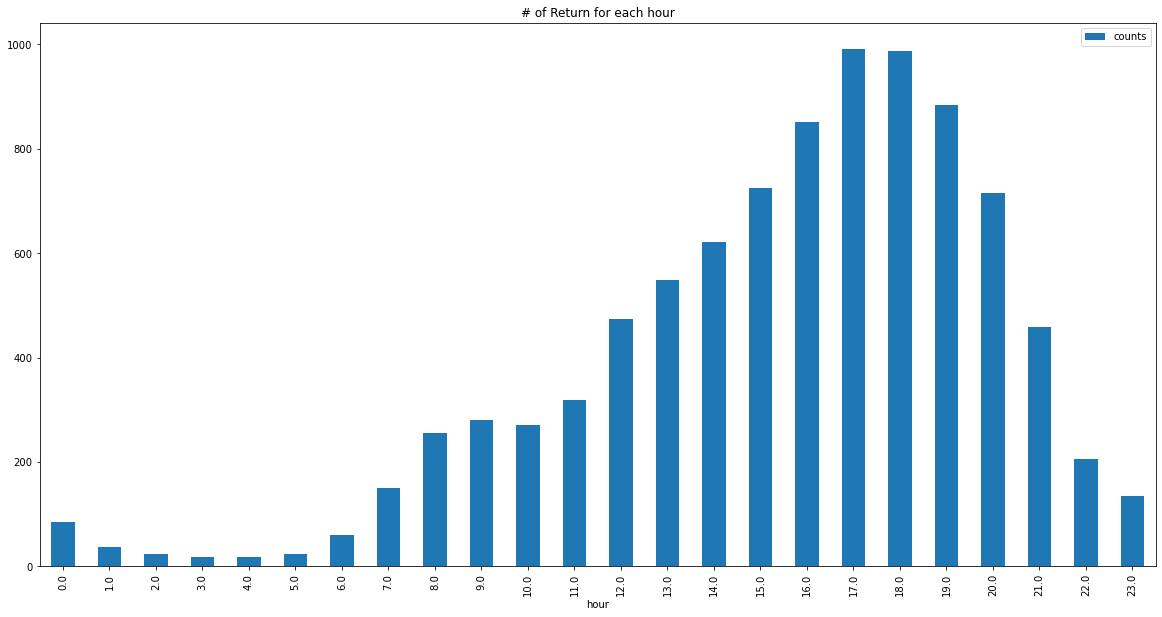

In [21]:
hours = predict_data_return.loc[:, ["hour", "counts"]]
hours["hour"] = (hours["hour"] * 23).round()
hours = hours.groupby("hour").sum()
hours.plot(kind='bar', figsize=(20, 10), title="# of Return for each hour")

In [22]:
# month = predict_data_return.loc[:, ["month", "counts"]]
# month["month"] = (month["month"] * 12).round()
# month = month.groupby("month").sum()
# month.plot(kind='bar', figsize=(20, 10), title="# of Return for each month");

[Text(0.5, 1.0, 'Top 10 return stations')]

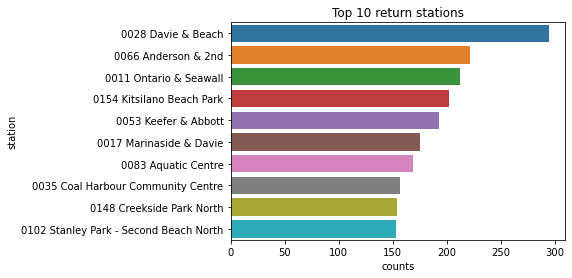

In [23]:
top_stations = predict_data_return[["station", "counts"]].groupby("station").sum().reset_index()
top_stations = top_stations.sort_values(by="counts", ascending= False).head(10)
ax = sns.barplot(x="counts", y="station", data=top_stations)
ax.set(title='Top 10 return stations')

In [24]:
predict_data = predict_data_departure.merge(
    predict_data_return, 
    left_on=['station', "month", "day", "hour"],
    right_on=['station', "month", "day", "hour"])
predict_data["ratio"] = predict_data["counts_x"] / predict_data["counts_y"]
predict_data = predict_data.rename(columns={"counts_x": "counts_departure", "counts_y": "counts_return"})
predict_data = predict_data[["station", "month", "day", "hour", "ratio", "counts_departure", "counts_return"]]
predict_data["month"] = (predict_data["month"] * 12).astype(int)
predict_data["day"] = (predict_data["day"] * 31).astype(int)
predict_data["hour"] = (predict_data["hour"] * 23).astype(int)
predict_data = predict_data.merge(stations[["station", "lat", "long"]], how="left", on="station")[["station", "lat", "long", "month", "day", "hour", "ratio", "counts_departure", "counts_return"]]

In [25]:
conditions = [
    predict_data["ratio"] < 1,
    predict_data["ratio"] > 5
]
choices = ["<1", ">5"]
predict_data["ratio"] = np.select(conditions, choices, default=predict_data["ratio"].astype(str))
predict_data.to_csv("../data/predict_result.csv")

In [26]:
# model_departure.save_model("model_departure.model")
# model_return.save_model("model_return.model")